In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
NOTE = '全特徴量を使用したSVM. class_weight は指定しない。Cは0.1'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '015_SVM_NOTbalanced_C01'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

015_submission.csv 015_SVM_NOTbalanced_C01


In [3]:
def get_estimator(categorical_features, discrete_features):
    discrete_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', discrete_transformer, discrete_features),
            ('categorical', 'passthrough', categorical_features),
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', SVC(C=0.1, random_state=SEED))
        ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [6]:
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [7]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(categorical_features, discrete_features)
    clf.fit(X_train, y_train)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[5058    8    0    0    0    0    0    0]
 [3687   59    0    0    0    0    0    0]
 [2385    8    0    0    0    0    0    0]
 [1706    3    0    0    0    0    0    0]
 [ 540    0    0    0    0    0    0    0]
 [ 150    0    0    0    0    0    0    0]
 [   8    0    0    0    0    0    0    0]
 [  96    0    0    0    0    0    0    0]]

**********Confusion matrix for validation set (Fold 1)**********
[[1265    2    0    0    0    0    0    0]
 [ 928    8    0    0    0    0    0    0]
 [ 597    2    0    0    0    0    0    0]
 [ 426    1    0    0    0    0    0    0]
 [ 134    1    0    0    0    0    0    0]
 [  37    0    0    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0]
 [  24    0    0    0    0    0    0    0]]

**********Confusion matrix for train set (Fold 2)**********
[[5066    0    0    0    0    0    0    0]
 [3743    3    0    0    0    0    0    0]
 [2393    0    0    0    0    0    0 

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.071382,0.069595
std,0.002429,0.001296
min,0.067668,0.067480
25%,0.070860,0.069666
50%,0.071492,0.069765
75%,0.072741,0.070051
max,0.074150,0.071012


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,0,0,1
2,2,0,0,0,1
3,3,2,0,0,1
4,4,4,0,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,1,0,5
17130,16833,1,1,0,5
17133,9762,1,0,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,7.288843,6.277508,5.231593,4.226433,2.840698,1.749101,-0.291691,0.723221,27446,1
1,7.289799,6.277524,5.233345,4.225359,2.834625,1.748061,-0.291750,0.722647,113,1
2,7.291022,6.281989,5.228029,4.209954,2.824476,1.747102,-0.291764,0.722573,4479,1
3,7.291057,6.281249,5.228393,4.213292,2.824886,1.746989,-0.291770,0.722584,29080,1
4,7.291174,6.278153,5.233985,4.213750,2.832989,1.749532,-0.291781,0.721843,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,6.280698,7.289113,5.224137,4.227030,2.846782,1.752269,-0.291891,0.719820,24272,5
33804,7.287433,6.269582,4.221502,5.251520,2.862462,1.753072,-0.291810,0.722616,29106,5
33805,7.286960,6.268583,4.223788,5.252992,2.860696,1.753419,-0.291815,0.722792,20679,5
33806,7.290909,6.271854,5.213906,4.242970,2.851600,1.751497,-0.291810,0.722226,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,36.437410,31.430331,26.188434,20.989744,14.140606,8.752096,-1.459833,3.603180
1,1,36.452777,31.400217,26.120953,21.115567,14.121567,8.750939,-1.459351,3.611431
2,2,36.440085,31.360369,26.209927,21.143602,14.283436,8.750522,-1.458699,3.617131
3,3,36.444540,31.401642,24.040095,23.178083,14.269547,8.747843,-1.459311,3.609623
4,4,36.454163,31.414695,26.106663,21.065038,14.129520,8.746839,-1.458734,3.607647
...,...,...,...,...,...,...,...,...,...
33803,33803,36.463483,31.384467,26.160698,21.007882,14.185365,8.745869,-1.459333,3.615667
33804,33804,36.450294,31.398100,20.993263,26.204061,14.179522,8.748851,-1.459912,3.613510
33805,33805,36.456368,31.391525,22.995696,24.164628,14.190954,8.743059,-1.458741,3.622329
33806,33806,36.425907,31.405510,26.213425,21.073161,14.243352,8.769504,-1.458745,3.605453


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,0


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.947823
1    0.052177
Name: y, dtype: float64

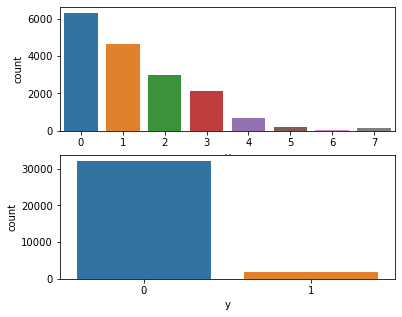

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.07138212387089372, 0.06959465874899791)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"015_submission.csv","Stratified-Kfold(K=5)","0.071382","0.069595","","全特徴量を使用したSVM. class_weight は指定しない。Cは0.1"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 3.45 s
